# QSeaBattle: Pyramid Trainable Assisted Imitation Learning (Per-level Bootstrap Tutorial)

This notebook mirrors the *linear* trainable-assisted bootstrap workflow, but for the **pyramid** architecture.

Key differences vs the linear tutorial:

- The pyramid reduces the active vector length by half at each level.
- For a flattened field length `N = field_size**2`, there are `K = log2(N)` levels with input sizes:
  `L ∈ {N, N/2, N/4, ..., 2}`.
- In this tutorial we follow **Option 2A**: **train each level separately** and then assemble Model A and Model B
  using per-level layers.

We will:
1. Set the working directory to repo root and import QSeaBattle modules.
2. Define the game layout and training hyperparameters.
3. Generate per-level imitation datasets (teacher targets).
4. Train per-level layers for A and B.
5. Assemble pyramid Model A / Model B and transfer learned weights.
6. Verify against the deterministic (teacher) strategy and run a small evaluation tournament.
7. Save model weights.

> Notes:
> - The pyramid models use the SharedRandomnessLayer internally. For *deterministic checks* we set `sr_mode="expected"`.
> - For gameplay / evaluation we set `sr_mode="sample"`.


## Current scope vs future DIAL end-to-end training

This tutorial implements **imitation bootstrap** for the pyramid architecture:

- We generate synthetic teacher targets for each layer type (measurement A/B, combine A/B).
- We train each level **independently** (Option 2A) using supervised losses.
- We assemble the full pyramid Model A / Model B by **transferring weights** into per-level layer lists.

### Limitation (intentional for now)
This notebook **does not** train communication end-to-end. In particular:

- The message (comm) is treated as a *supervised target* (via teacher rules) rather than learned jointly.
- The `SharedRandomnessLayer` is used in `"expected"` mode for deterministic checks and `"sample"` mode for gameplay,
  but we **do not** backpropagate through stochastic sampling.

### What will change for DIAL/DRU end-to-end (future work)
To move to true end-to-end DIAL/DRU for the pyramid model, we will likely:
1. Make Model A output a **continuous message** (logits) during training and discretize only for evaluation/gameplay.
2. Let Model B consume that continuous message directly during training.
3. Introduce a differentiable treatment of discrete sampling:
   - straight-through estimators (DIAL/DRU style), or
   - relaxed Bernoulli / Gumbel-sigmoid for comm and possibly for SR outcomes.
4. Add end-to-end training utilities that optimize a **game-level loss** (e.g., BCE on correct shoot decision)
   across the full K-level pyramid computation graph.

The supervised imitation stage here is still useful in that setting as **pretraining** before end-to-end fine-tuning.


In [34]:
from __future__ import annotations

import os
import sys
from pathlib import Path

def change_to_repo_root(marker: str = "src") -> None:
    """Change CWD to the repository root (parent of `src`)."""
    here = Path.cwd()
    for parent in [here] + list(here.parents):
        if (parent / marker).is_dir():
            os.chdir(parent)
            break

change_to_repo_root("src")
sys.path.append("./src")

print("CWD:", Path.cwd())


CWD: c:\Users\nly99857\OneDrive - Philips\SW Projects\QSeaBattle


## Imports


In [35]:
import numpy as np
import tensorflow as tf

from Q_Sea_Battle.game_layout import GameLayout
from Q_Sea_Battle.game_env import GameEnv
from Q_Sea_Battle.tournament import Tournament

from Q_Sea_Battle.trainable_assisted_players import TrainableAssistedPlayers

from Q_Sea_Battle.pyr_trainable_assisted_model_a import PyrTrainableAssistedModelA
from Q_Sea_Battle.pyr_trainable_assisted_model_b import PyrTrainableAssistedModelB

from Q_Sea_Battle.pyr_trainable_assisted_imitation_utils import (
    pyramid_levels,
    generate_measurement_dataset_a_level,
    generate_combine_dataset_a_level,
    generate_measurement_dataset_b_level,
    generate_combine_dataset_b_level,
    to_tf_dataset,
    train_layer,
    transfer_pyr_model_a_layer_weights,
    transfer_pyr_model_b_layer_weights,
)

print("TensorFlow:", tf.__version__)
tf.get_logger().setLevel("ERROR")

TensorFlow: 2.20.0


## Game layout and correlation setting


In [36]:
FIELD_SIZE = 4          # 4x4 -> N=16 (requires N a power of 2)
COMMS_SIZE = 1            # Pyramid requires 1 comm bit

# Shared-randomness correlation parameter (passed into the pyramid models' SR layers)
P_HIGH = 1.0

# Dataset / training sizes
DATASET_SIZE = 50_000
BATCH_SIZE = 256

EPOCHS_MEAS_A = 15         
EPOCHS_MEAS_B = 30
EPOCHS_COMB_A = 15
EPOCHS_COMB_B = 15

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Folders
data_dir = Path("notebooks/data")
models_dir = Path("notebooks/models")
data_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

layout = GameLayout(field_size=FIELD_SIZE, comms_size=COMMS_SIZE)
N = FIELD_SIZE * FIELD_SIZE
levels = pyramid_levels(N)

print("Flattened N:", N)
print("Pyramid levels (input sizes):", levels)

# Optional: show or hide per-epoch progress bars from Keras .fit()
FIT_VERBOSE = 1  # 0 = silent, 1 = progress bar, 2 = one line per epoch

Flattened N: 16
Pyramid levels (input sizes): [16, 8, 4, 2]


## Generating imitation targets from the classical assisted strategy (teacher rules)

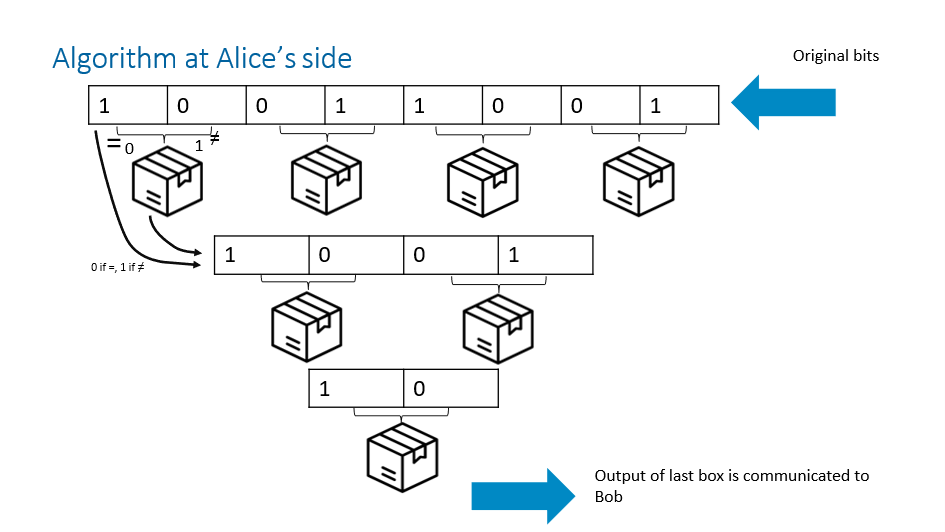

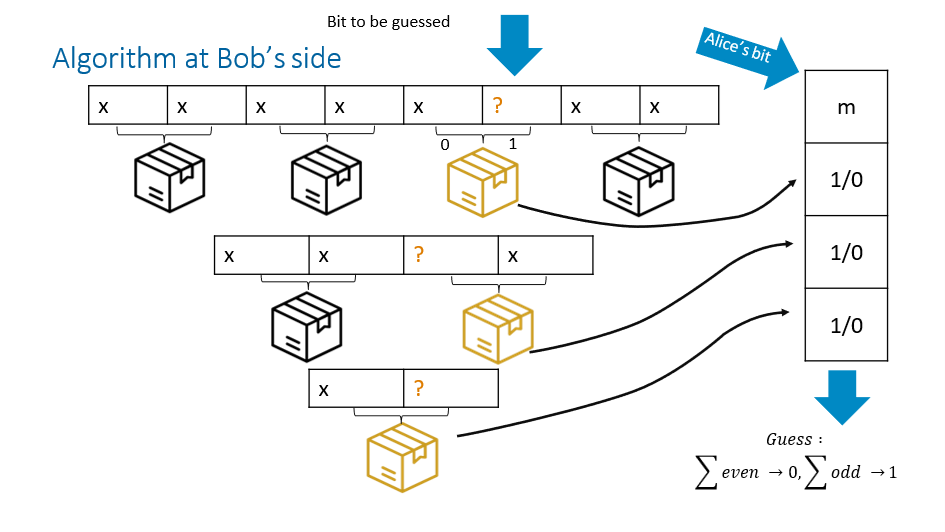

This represents the correct rules (checked for field size 8 and 16)
- Measurement A: Consider odd/even pairs in the input field. If pair equal, measure 0, if pair different, measure 1.
$$
m_i(A)=x_{2i}⊕x_{2i+1}
$$

- Combine A: Consider the outcome and the even index of the pair in the field, if the these are equal output 0, if these are unequal output 1
$$
f'_i=x_{2i}⊕s_i
$$

- Measure B: Measurement B outputs 1 if and only if the gun pair equals (0,1); otherwise it outputs 0.
$$
m_i(B)=¬g_{2i}∧g_{2i+1}
$$

- Combine B to new gun: If the pair in original gun is (0,1) or (1,0) set to 1, otherwise set to 0. In other words, the next gun state is defined as $g'_i=g_{2i}⊕g_{2i+1}$. If the current gun is one-hot, this operation preserves one-hotness. 
	
- Based on A’ measurement (input) to shared randomness and the output of A’s shared randomness, and the setting Phigh B produces and output for his shared randomness, which is not necessarily equal to the output of A’s shared randomness. 

- New comms: If the shared-randomness outcome at the index with value ‘1’ in new gun is 1, flip the original comms, otherwise leave the original comms the same to produce new comms. Let g^'be the new gun (one-hot) and sthe shared-randomness vector that is produced by B’s measurement. The updated  communication bit is 
$$
c' = c \oplus \left(\sum_i g'_i s_i\right) \bmod 2
$$

Notes: 
* The gun vector is assumed to be one-hot at all levels; the pyramid update rule preserves this invariant.
* Shared randomness does not affect the gun state. It is used only to update the communication bit.




In [37]:
# For each level size L we generate independent synthetic inputs of length L,
# and compute supervised teacher targets according to the v2 pyramid rules.

datasets = {
    "meas_a": {},
    "comb_a": {},
    "meas_b": {},
    "comb_b": {},
}

for i, L in enumerate(levels):
    datasets["meas_a"][L] = generate_measurement_dataset_a_level(L, num_samples=DATASET_SIZE, seed=SEED + 10 + i)
    datasets["comb_a"][L] = generate_combine_dataset_a_level(L, num_samples=DATASET_SIZE, seed=SEED + 20 + i)
    datasets["meas_b"][L] = generate_measurement_dataset_b_level(L, num_samples=DATASET_SIZE, seed=SEED + 30 + i)
    datasets["comb_b"][L] = generate_combine_dataset_b_level(L, num_samples=DATASET_SIZE, seed=SEED + 40 + i)

print("Generated datasets for levels:", list(datasets["meas_a"].keys()))


Generated datasets for levels: [16, 8, 4, 2]


In [38]:
# ============================================================
# Pyramid per-layer dataset sanity check & manual inspection
# ============================================================

import numpy as np
import random

np.set_printoptions(precision=3, suppress=True, linewidth=120)

print("=== Pyramid Dataset Diagnostic ===")

def pick_one(ds_dict):
    """Pick one random index from a dataset dict of numpy arrays."""
    n = len(next(iter(ds_dict.values())))
    i = random.randrange(n)
    return {k: v[i] for k, v in ds_dict.items()}, i


def frac_binary(x):
    x = np.asarray(x)
    return np.mean((x == 0) | (x == 1))


def summarize(name, arr):
    arr = np.asarray(arr)
    print(f"{name:>18}: shape={arr.shape}, min={arr.min():.3f}, max={arr.max():.3f}, "
          f"mean={arr.mean():.3f}, frac_binary={frac_binary(arr):.3f}")


for L in levels:
    print("\n" + "="*70)
    print(f"LEVEL L = {L}")
    print("="*70)

    # --------------------------------------------------------
    # Measurement A
    # --------------------------------------------------------
    ds = datasets["meas_a"][L]
    sample, idx = pick_one(ds)

    field = sample["field"]
    target = sample["meas_target"]

    print("\n[Measurement A]")
    print(f"Sample index: {idx}")
    summarize("field", field)
    summarize("meas_target", target)
    print(f'Example: \n\tField: {field}\n\tTarget: {target}')

    print("Rule check:")
    print("- field length =", len(field))
    print("- meas_target length =", len(target), "(expected L//2)")
    print("- Each target bit should indicate inequality of a field pair")

    # --------------------------------------------------------
    # Combine A
    # --------------------------------------------------------
    ds = datasets["comb_a"][L]
    sample, idx = pick_one(ds)

    field = sample["field"]
    sr = sample["sr_outcome"]
    target = sample["next_field_target"]

    print("\n[Combine A]")
    print(f"Sample index: {idx}")
    summarize("field", field)
    summarize("sr_outcome", sr)
    summarize("next_field", target)
    print(f'Example: \n\tField: {field}\n\tSR Outcome: {sr}\n\tNext Field: {target}')

    print("Rule check:")
    print("- sr_outcome length =", len(sr), "(expected L//2)")
    print("- next_field length =", len(target), "(expected L//2)")
    print("- next_field combines field + SR outcome")

    # --------------------------------------------------------
    # Measurement B
    # --------------------------------------------------------
    ds = datasets["meas_b"][L]
    sample, idx = pick_one(ds)

    gun = sample["gun"]
    target = sample["meas_target"]

    print("\n[Measurement B]")
    print(f"Sample index: {idx}")
    summarize("gun", gun)
    summarize("meas_target", target)
    print(f'Example: \n\tGun: {gun}\n\tTarget: {target}')

    print("Rule check:")
    print("- gun length =", len(gun))
    print("- meas_target length =", len(target), "(expected L//2)")

    # --------------------------------------------------------
    # Combine B
    # --------------------------------------------------------
    ds = datasets["comb_b"][L]
    sample, idx = pick_one(ds)

    gun = sample["gun"]
    sr = sample["sr_outcome"]
    comm = sample["comm"]
    tgt_g = sample["next_gun_target"]
    tgt_c = sample["next_comm_target"]
    print(f'Example: \n\tGun: {gun}\n\tSR Outcome: {sr}\n\tComm: {comm}\n\tNext Gun: {tgt_g}\n\tNext Comm: {tgt_c}')

    print("\n[Combine B]")
    print(f"Sample index: {idx}")
    summarize("gun", gun)
    summarize("sr_outcome", sr)
    summarize("comm", comm)
    summarize("next_gun", tgt_g)
    summarize("next_comm", tgt_c)

    print("Rule check:")
    print("- next_gun length =", len(tgt_g), "(expected L//2)")
    print("- next_comm length =", len(tgt_c), "(expected COMMS_SIZE)")
    print("- next_comm aggregates information from SR + gun")

print("\n=== Diagnostic complete ===")


=== Pyramid Dataset Diagnostic ===

LEVEL L = 16

[Measurement A]
Sample index: 43548
             field: shape=(16,), min=0.000, max=1.000, mean=0.750, frac_binary=1.000
       meas_target: shape=(8,), min=0.000, max=1.000, mean=0.250, frac_binary=1.000
Example: 
	Field: [1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
	Target: [0. 0. 1. 0. 0. 0. 1. 0.]
Rule check:
- field length = 16
- meas_target length = 8 (expected L//2)
- Each target bit should indicate inequality of a field pair

[Combine A]
Sample index: 9746
             field: shape=(16,), min=0.000, max=1.000, mean=0.625, frac_binary=1.000
        sr_outcome: shape=(8,), min=0.000, max=1.000, mean=0.500, frac_binary=1.000
        next_field: shape=(8,), min=0.000, max=1.000, mean=0.500, frac_binary=1.000
Example: 
	Field: [0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.]
	SR Outcome: [1. 1. 0. 1. 0. 0. 0. 1.]
	Next Field: [1. 0. 0. 1. 1. 1. 0. 0.]
Rule check:
- sr_outcome length = 8 (expected L//2)
- next_field length = 8 (

## Training individual layers by supervised imitation (per level)


### Training notes

- We report `binary_accuracy` during supervised imitation to quickly detect learnability issues.
- If you see accuracy stuck near `0.5` with loss near `0.693`, the model is underpowered for XOR-like rules.
  Increase `hidden` or add another hidden layer.
- `FIT_VERBOSE` controls Keras `.fit()` output (0/1/2).

> For this notebook, `train_layer(...)` is expected to accept a `verbose` argument.  
> If your local `pyr_trainable_assisted_imitation_utils.py` does not yet include it, add `verbose` to that helper
> (same as in the linear tutorial).


In [39]:
# We'll define small per-level trainable layers.
# IMPORTANT: a single Dense(L -> L/2) cannot learn XOR-like rules (not linearly separable),
# so we use a tiny MLP (Dense -> ReLU -> Dense) to make the mapping learnable *without*
# hard-coding the teacher algorithm/structure. This keeps the model flexible for future
# end-to-end (DIAL/DRU) experiments.

class PyrMeasTrainable(tf.keras.layers.Layer):
    """Trainable measurement: MLP(L -> hidden -> L/2) with sigmoid output."""
    def __init__(self, L: int, hidden: int = 64):
        super().__init__()
        self.L = int(L)
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden, activation="relu"),
            tf.keras.layers.Dense(self.L // 2, activation="sigmoid"),
        ])

    def call(self, x):
        x = tf.cast(x, tf.float32)
        return self.net(x)

class PyrCombineATrainable(tf.keras.layers.Layer):
    """Trainable combine A: concat(field, sr_outcome) -> MLP -> next_field (L/2)."""
    def __init__(self, L: int, hidden: int = 64):
        super().__init__()
        self.L = int(L)
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden, activation="relu"),
            tf.keras.layers.Dense(self.L // 2, activation="sigmoid"),
        ])

    def call(self, field, sr_outcome):
        field = tf.cast(field, tf.float32)
        sr_outcome = tf.cast(sr_outcome, tf.float32)
        z = tf.concat([field, sr_outcome], axis=-1)
        return self.net(z)

class PyrCombineBTrainable(tf.keras.layers.Layer):
    """Trainable combine B: concat(gun, sr_outcome, comm) -> trunk MLP -> (next_gun, next_comm)."""
    def __init__(self, L: int, hidden: int = 64):
        super().__init__()
        self.L = int(L)
        self.trunk = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden, activation="relu"),
        ])
        self.head_g = tf.keras.layers.Dense(self.L // 2, activation="sigmoid")
        self.head_c = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, gun, sr_outcome, comm):
        gun = tf.cast(gun, tf.float32)
        sr_outcome = tf.cast(sr_outcome, tf.float32)
        comm = tf.cast(comm, tf.float32)
        z = tf.concat([gun, sr_outcome, comm], axis=-1)
        h = self.trunk(z)
        return self.head_g(h), self.head_c(h)


bce = tf.keras.losses.BinaryCrossentropy()



meas_layers_a_trained = []
comb_layers_a_trained = []
meas_layers_b_trained = []
comb_layers_b_trained = []

for L in levels:
    print(f"Training per-level layers for L={L}...")

    # --- Measurement A ---
    ds = datasets["meas_a"][L]
    tfds = to_tf_dataset(ds, x_keys=["field"], y_key="meas_target",
                         batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
    layer = PyrMeasTrainable(L)
    _ = train_layer(layer, tfds, loss=bce, epochs=EPOCHS_MEAS_A, metrics=["binary_accuracy"], verbose=FIT_VERBOSE)
    meas_layers_a_trained.append(layer)
    print(f" \tTrained Measurement A layer for L={L}.")

    # --- Combine A ---
    ds = datasets["comb_a"][L]
    tfds = to_tf_dataset(ds, x_keys=["field", "sr_outcome"], y_key="next_field_target",
                         batch_size=BATCH_SIZE, shuffle=True, seed=SEED+1)
    layer = PyrCombineATrainable(L)
    _ = train_layer(layer, tfds, loss=bce, epochs=EPOCHS_COMB_A, metrics=["binary_accuracy"], verbose=FIT_VERBOSE)
    comb_layers_a_trained.append(layer)
    print(f" \tTrained Combine A layer for L={L}.")

    # --- Measurement B ---
    ds = datasets["meas_b"][L]
    tfds = to_tf_dataset(ds, x_keys=["gun"], y_key="meas_target",
                         batch_size=BATCH_SIZE, shuffle=True, seed=SEED+2)
    layer = PyrMeasTrainable(L)
    _ = train_layer(layer, tfds, loss=bce, epochs=EPOCHS_MEAS_B, metrics=["binary_accuracy"], verbose=FIT_VERBOSE)
    meas_layers_b_trained.append(layer)
    print(f" \tTrained Measurement B layer for L={L}.")

    # --- Combine B (multi-output) ---
    ds = datasets["comb_b"][L]

    gun = ds["gun"]
    sr_out = ds["sr_outcome"]
    comm = ds["comm"]
    y_g = ds["next_gun_target"]
    y_c = ds["next_comm_target"]

    tfds = tf.data.Dataset.from_tensor_slices(((gun, sr_out, comm), (y_g, y_c)))
    tfds = tfds.shuffle(buffer_size=min(len(gun), 10_000),
                        seed=SEED+3, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    layer = PyrCombineBTrainable(L)

    inp_g = tf.keras.Input(shape=(L,), dtype=tf.float32)
    inp_sr = tf.keras.Input(shape=(L//2,), dtype=tf.float32)
    inp_c = tf.keras.Input(shape=(COMMS_SIZE,), dtype=tf.float32)
    out_g, out_c = layer(inp_g, inp_sr, inp_c)

    out_g = tf.keras.layers.Activation("linear", name="next_gun")(out_g)
    out_c = tf.keras.layers.Activation("linear", name="next_comm")(out_c)

    model = tf.keras.Model([inp_g, inp_sr, inp_c], [out_g, out_c])
    model.compile(
        optimizer="adam",
        loss=[bce, bce],
        metrics=[["binary_accuracy"], ["binary_accuracy"]],
    )
    model.fit(tfds, epochs=EPOCHS_COMB_B, verbose=FIT_VERBOSE)

    comb_layers_b_trained.append(layer)
    print(f" \tTrained Combine B layer for L={L}.")

print("Trained per-level layers for A and B.")


Training per-level layers for L=16...
Epoch 1/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - binary_accuracy: 0.5846 - loss: 0.6801
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 0.8246 - loss: 0.5900
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 0.9695 - loss: 0.4259
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.9979 - loss: 0.2682
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.1620
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.0990
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.0626
Epoch 8/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.0415
Epoch 9/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.0289
Epoch 10/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 1.0000 - loss: 0.0209
Epoch 11/15
196/196 ━

## Assembling Model A and Model B (per-level layers + weight transfer)


In [40]:
# To mirror the linear tutorial workflow, we instantiate *fresh* pyramid models
# with fresh layer objects of the same architecture, then transfer weights.

# Create new (destination) layer lists
meas_layers_a_dst = [PyrMeasTrainable(L) for L in levels]
comb_layers_a_dst = [PyrCombineATrainable(L) for L in levels]
meas_layers_b_dst = [PyrMeasTrainable(L) for L in levels]
comb_layers_b_dst = [PyrCombineBTrainable(L) for L in levels]

# Build destination layers (so they have weights allocated)
for L, lyr in zip(levels, meas_layers_a_dst):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32))
for L, lyr in zip(levels, comb_layers_a_dst):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32), tf.zeros((1, L//2), dtype=tf.float32))
for L, lyr in zip(levels, meas_layers_b_dst):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32))
for L, lyr in zip(levels, comb_layers_b_dst):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32), tf.zeros((1, L//2), dtype=tf.float32), tf.zeros((1, 1), dtype=tf.float32))

# Build trained layers too (in case they haven't been built yet)
for L, lyr in zip(levels, meas_layers_a_trained):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32))
for L, lyr in zip(levels, comb_layers_a_trained):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32), tf.zeros((1, L//2), dtype=tf.float32))
for L, lyr in zip(levels, meas_layers_b_trained):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32))
for L, lyr in zip(levels, comb_layers_b_trained):
    _ = lyr(tf.zeros((1, L), dtype=tf.float32), tf.zeros((1, L//2), dtype=tf.float32), tf.zeros((1, 1), dtype=tf.float32))

# Create pyramid models (use sr_mode expected for deterministic sanity checks)
model_a = PyrTrainableAssistedModelA(layout, p_high=P_HIGH, sr_mode="expected", measure_layers=meas_layers_a_dst, combine_layers=comb_layers_a_dst)
model_b = PyrTrainableAssistedModelB(layout, p_high=P_HIGH, sr_mode="expected", measure_layers=meas_layers_b_dst, combine_layers=comb_layers_b_dst)

# Transfer weights from trained layers into the models
transfer_pyr_model_a_layer_weights(model_a, meas_layers_a_trained, comb_layers_a_trained)
transfer_pyr_model_b_layer_weights(model_b, meas_layers_b_trained, comb_layers_b_trained)

print("Assembled pyramid Model A and Model B with transferred per-level weights.")


Assembled pyramid Model A and Model B with transferred per-level weights.


In [41]:
# --- Weight-transfer sanity check (paste as a cell) ---
import numpy as np

def _assert_layer_weights_equal(src_layer, dst_layer, name: str):
    src_w = src_layer.get_weights()
    dst_w = dst_layer.get_weights()
    assert len(src_w) == len(dst_w), f"{name}: number of weight arrays differs ({len(src_w)} vs {len(dst_w)})"
    for i, (a, b) in enumerate(zip(src_w, dst_w)):
        assert a.shape == b.shape, f"{name}[{i}]: shape mismatch {a.shape} vs {b.shape}"
        np.testing.assert_allclose(a, b, atol=0.0, rtol=0.0, err_msg=f"{name}[{i}]: weights differ")

def assert_pyr_transfer_ok(model_a, model_b,
                           meas_a_trained, comb_a_trained,
                           meas_b_trained, comb_b_trained):
    def _get_list(obj, candidates):
        for c in candidates:
            if hasattr(obj, c):
                return getattr(obj, c)
        raise AttributeError(f"Could not find any of {candidates} on {type(obj).__name__}")

    a_meas = _get_list(model_a, ["measure_layers", "meas_layers", "measurement_layers"])
    a_comb = _get_list(model_a, ["combine_layers", "comb_layers"])
    b_meas = _get_list(model_b, ["measure_layers", "meas_layers", "measurement_layers"])
    b_comb = _get_list(model_b, ["combine_layers", "comb_layers"])

    # Length checks
    assert len(a_meas) == len(meas_a_trained), f"Model A meas layers length {len(a_meas)} != trained {len(meas_a_trained)}"
    assert len(a_comb) == len(comb_a_trained), f"Model A comb layers length {len(a_comb)} != trained {len(comb_a_trained)}"
    assert len(b_meas) == len(meas_b_trained), f"Model B meas layers length {len(b_meas)} != trained {len(meas_b_trained)}"
    assert len(b_comb) == len(comb_b_trained), f"Model B comb layers length {len(b_comb)} != trained {len(comb_b_trained)}"

    # Determine L0 robustly (prefer trained-layer metadata)
    L0 = None
    for cand in (meas_a_trained, comb_a_trained, meas_b_trained, comb_b_trained):
        if len(cand) > 0 and hasattr(cand[0], "L"):
            L0 = int(cand[0].L)
            break
    if L0 is None:
        raise ValueError("Could not infer base length L0 (expected trained layers to have attribute .L).")

    # Build/touch models once so weights exist
    dummy_field = np.zeros((1, L0), dtype=np.float32)
    _ = model_a.compute_with_internal(dummy_field)

    dummy_gun  = np.zeros((1, L0), dtype=np.float32)
    dummy_comm = np.zeros((1, 1), dtype=np.float32)
    _, dummy_meas, dummy_out = model_a.compute_with_internal(dummy_field)
    _ = model_b([dummy_gun, dummy_comm, dummy_meas, dummy_out])

    # Per-level comparisons
    for i, (src, dst) in enumerate(zip(meas_a_trained, a_meas)):
        _assert_layer_weights_equal(src, dst, f"A.measure[{i}]")
    for i, (src, dst) in enumerate(zip(comb_a_trained, a_comb)):
        _assert_layer_weights_equal(src, dst, f"A.combine[{i}]")

    for i, (src, dst) in enumerate(zip(meas_b_trained, b_meas)):
        _assert_layer_weights_equal(src, dst, f"B.measure[{i}]")
    for i, (src, dst) in enumerate(zip(comb_b_trained, b_comb)):
        _assert_layer_weights_equal(src, dst, f"B.combine[{i}]")

    print("✅ Weight transfer check passed: all per-level layer weights match exactly.")

assert_pyr_transfer_ok(
    model_a, model_b,
    meas_layers_a_trained, comb_layers_a_trained,
    meas_layers_b_trained, comb_layers_b_trained
)


✅ Weight transfer check passed: all per-level layer weights match exactly.


### Verification: neural vs deterministic pyramid primitives (quick contract check)


In [42]:
# We compare the *structure* and run a single forward pass to ensure no shape/contract errors.
# For a deterministic comparison, we use sr_mode="expected" for both.

# Deterministic baseline models (Step-1 primitives at each level)
baseline_a = PyrTrainableAssistedModelA(layout, p_high=P_HIGH, sr_mode="expected")
baseline_b = PyrTrainableAssistedModelB(layout, p_high=P_HIGH, sr_mode="expected")

# Random test batch
B = 64
field = tf.constant(np.random.randint(0, 2, size=(B, N)).astype(np.float32))
gun = tf.constant(np.random.randint(0, 2, size=(B, N)).astype(np.float32))
comm0 = tf.zeros((B, 1), dtype=tf.float32)

# A forward
logits_a, meas_a, out_a = model_a.compute_with_internal(field)
logits_a0, meas_a0, out_a0 = baseline_a.compute_with_internal(field)

print("A: logits shape:", logits_a.shape, "K:", len(meas_a), "last length:", meas_a[-1].shape[-1])

# B forward (consumes A's lists)
shoot_logit = model_b([gun, comm0, meas_a, out_a])
shoot_logit0 = baseline_b([gun, comm0, meas_a0, out_a0])

print("B: shoot_logit shape:", shoot_logit.shape)


A: logits shape: (64, 1) K: 4 last length: 1
B: shoot_logit shape: (64, 1)


### Bootstrap tournament evaluation (gameplay uses sr_mode='sample')


In [43]:
# For gameplay evaluation, use sr_mode="sample"
model_a_eval = PyrTrainableAssistedModelA(layout, p_high=P_HIGH, sr_mode="sample",
                                         measure_layers=meas_layers_a_dst, combine_layers=comb_layers_a_dst)
model_b_eval = PyrTrainableAssistedModelB(layout, p_high=P_HIGH, sr_mode="sample",
                                         measure_layers=meas_layers_b_dst, combine_layers=comb_layers_b_dst)

# Transfer weights from trained layers into the models
transfer_pyr_model_a_layer_weights(model_a_eval, meas_layers_a_trained, comb_layers_a_trained)
transfer_pyr_model_b_layer_weights(model_b_eval, meas_layers_b_trained, comb_layers_b_trained)

# Ensure weights are present (same objects as dst lists already have weights transferred)
players = TrainableAssistedPlayers(layout, model_a=model_a_eval, model_b=model_b_eval)

layout_eval = GameLayout(
    field_size=FIELD_SIZE,
    comms_size=COMMS_SIZE,
    enemy_probability=0.5,
    channel_noise=0.0,
    number_of_games_in_tournament=2_000,
)

env = GameEnv(layout_eval)
t = Tournament(env, players, layout_eval)
log = t.tournament()
mean_reward, std_err = log.outcome()
print(f"Pyramid bootstrap tournament over {layout_eval.number_of_games_in_tournament}: {mean_reward:.4f} ± {std_err:.4f}")


Pyramid bootstrap tournament over 2000: 0.9525 ± 0.0048


In [44]:
field = tf.zeros((1,16), tf.float32)
logit, meas, out = model_a_eval.compute_with_internal(field)
print(len(meas), [m.shape for m in meas])
print(len(out),  [o.shape for o in out])

gun = tf.zeros((1,16), tf.float32)
comm = tf.zeros((1,1), tf.float32)
shoot = model_b_eval([gun, comm, meas, out])
print("shoot shape:", shoot.shape)

for i, sr in enumerate(model_a_eval.sr_layers):
    print("A sr", i, getattr(sr, "mode", None), getattr(sr, "p_high", None))
for i, sr in enumerate(model_b_eval.sr_layers):
    print("B sr", i, getattr(sr, "mode", None), getattr(sr, "p_high", None))


4 [TensorShape([1, 8]), TensorShape([1, 4]), TensorShape([1, 2]), TensorShape([1, 1])]
4 [TensorShape([1, 8]), TensorShape([1, 4]), TensorShape([1, 2]), TensorShape([1, 1])]
shoot shape: (1, 1)
A sr 0 sample 1.0
A sr 1 sample 1.0
A sr 2 sample 1.0
A sr 3 sample 1.0
B sr 0 sample 1.0
B sr 1 sample 1.0
B sr 2 sample 1.0
B sr 3 sample 1.0


In [45]:
# --- Single-game SR contract diagnostic (paste as one cell) ---

import numpy as np

# 1) Run exactly one game via Tournament, so we capture what Player A stored as "prev_*"
layout_one = GameLayout(field_size=layout_eval.field_size, 
                        comms_size=layout_eval.comms_size,
                        number_of_games_in_tournament=1)


env_one = GameEnv(layout_one)
t_one = Tournament(env_one, players, layout_one)
log_one = t_one.tournament()

row0 = log_one.log.iloc[0]
prev_meas = row0["prev_measurements"]
prev_out  = row0["prev_outcomes"]

print("=== Logged prev from Player A ===")
print("type(prev_meas):", type(prev_meas))
print("type(prev_out): ", type(prev_out))

assert prev_meas is not None and prev_out is not None, "No prev_* logged; does players.has_prev=True and PlayerA.get_prev() return data?"
assert isinstance(prev_meas, (list, tuple)) and isinstance(prev_out, (list, tuple)), "prev_* must be lists/tuples"
assert len(prev_meas) == len(prev_out), "prev_meas/out length mismatch"

K = len(prev_meas)
print("K (depth) =", K)
print("meas shapes:", [np.array(x).shape for x in prev_meas])
print("out  shapes:", [np.array(x).shape for x in prev_out])

# 2) Basic per-level shape alignment sanity:
#    At level ℓ with current length L_ℓ, measurement/outcome should have length L_ℓ/2.
#    We infer L_0 from game field size; then halve each level.
L0 = layout_one.field_size**2
L = L0
for ell in range(K):
    m = np.array(prev_meas[ell])
    o = np.array(prev_out[ell])
    expected = L // 2
    assert m.shape[-1] == expected, f"Level {ell}: meas last-dim {m.shape[-1]} != {expected}"
    assert o.shape[-1] == expected, f"Level {ell}: out  last-dim {o.shape[-1]} != {expected}"
    L = expected

print("✅ Per-level dimensionality matches halving contract.")

# 3) Non-triviality / SR usage quick check:
#    In EXPECTED mode, outcomes may be probabilities (often ~p_high / 1-p_high) not exactly {0,1}.
#    In SAMPLE mode, outcomes should be near-binary most of the time.
def summary(arr):
    arr = np.array(arr).astype(np.float32).ravel()
    return dict(min=float(arr.min()), max=float(arr.max()), mean=float(arr.mean()), frac_mid=float(((arr > 1e-3) & (arr < 1-1e-3)).mean()))

print("\n=== Outcome value summaries per level ===")
for ell, o in enumerate(prev_out):
    s = summary(o)
    print(f"ℓ={ell}: min={s['min']:.4f}, max={s['max']:.4f}, mean={s['mean']:.4f}, frac_in_(0,1)={s['frac_mid']:.3f}")

print("\nInterpretation tip:")
print("- If sr_mode='expected': expect many values strictly between 0 and 1 (frac_in_(0,1) high).")
print("- If sr_mode='sample': expect values close to 0/1 (frac_in_(0,1) near 0).")

# 4) (Optional) Directly exercise Model B with the *logged* prev lists to ensure it accepts them.
#    We re-create gun/comm from the logged game to match batch dims.
gun  = row0["gun"]
comm = row0["comm"]
gun  = np.array(gun, dtype=np.float32)[None, :] if gun.ndim == 1 else np.array(gun, dtype=np.float32)
comm = np.array(comm, dtype=np.float32)[None, :] if comm.ndim == 1 else np.array(comm, dtype=np.float32)

shoot_logit = model_b([gun, comm, prev_meas, prev_out])
print("\nModel B call with logged prev succeeded. shoot_logit shape:", shoot_logit.shape)


=== Logged prev from Player A ===
type(prev_meas): <class 'list'>
type(prev_out):  <class 'list'>
K (depth) = 4
meas shapes: [(1, 8), (1, 4), (1, 2), (1, 1)]
out  shapes: [(1, 8), (1, 4), (1, 2), (1, 1)]
✅ Per-level dimensionality matches halving contract.

=== Outcome value summaries per level ===
ℓ=0: min=0.0000, max=1.0000, mean=0.7500, frac_in_(0,1)=0.000
ℓ=1: min=0.0000, max=1.0000, mean=0.5000, frac_in_(0,1)=0.000
ℓ=2: min=0.0000, max=1.0000, mean=0.5000, frac_in_(0,1)=0.000
ℓ=3: min=1.0000, max=1.0000, mean=1.0000, frac_in_(0,1)=0.000

Interpretation tip:
- If sr_mode='expected': expect many values strictly between 0 and 1 (frac_in_(0,1) high).
- If sr_mode='sample': expect values close to 0/1 (frac_in_(0,1) near 0).

Model B call with logged prev succeeded. shoot_logit shape: (1, 1)


In [46]:
import numpy as np

# After: comm_np = player_a.decide(field_np, explore=False)
prev_meas, prev_out = players.previous  # lists of per-level batched tensors
field0 = np.array(field_np, dtype=np.float32)[None, :]  # (1, N)

F = field0
for ell, S in enumerate(prev_out):
    S = np.array(S)  # (1, L/2)
    even = F[:, ::2]  # (1, L/2)
    F_next_expected = np.logical_xor(even > 0.5, S > 0.5).astype(np.float32)
    # move to next level
    F = F_next_expected

# After last level, F has shape (1,1) and equals the comm bit A should output
comm_expected = int(F[0, 0] >= 0.5)
comm_got = int(np.asarray(comm_np).reshape(-1)[0] >= 0.5)

assert comm_expected == comm_got, f"Comm inconsistent with stored outcomes: expected {comm_expected}, got {comm_got}"
print("✅ Player A is self-consistent: comm matches the stored per-level SR outcomes under the Combine-A rule.")


✅ Player A is self-consistent: comm matches the stored per-level SR outcomes under the Combine-A rule.


### Save weights


In [47]:
# Save weights (one file per model). Include field/comms and p_high in the filename.
model_a_path = models_dir / f"pyr_model_a_bootstrap_f{FIELD_SIZE}_m{COMMS_SIZE}_p{P_HIGH:.2f}.weights.h5"
model_b_path = models_dir / f"pyr_model_b_bootstrap_f{FIELD_SIZE}_m{COMMS_SIZE}_p{P_HIGH:.2f}.weights.h5"

# Keras requires models to be built before saving weights.
# Build by calling once with dummy inputs.
dummy_field = tf.zeros((1, N), dtype=tf.float32)
dummy_gun = tf.zeros((1, N), dtype=tf.float32)
dummy_comm = tf.zeros((1, 1), dtype=tf.float32)

_ = model_a(dummy_field)
_, prev_meas, prev_out = model_a.compute_with_internal(dummy_field)
_ = model_b([dummy_gun, dummy_comm, prev_meas, prev_out])

# Save the deterministic (expected) versions' weights (same layer weights).
model_a.save_weights(model_a_path)
model_b.save_weights(model_b_path)

print("Saved weights:")
print(" -", model_a_path)
print(" -", model_b_path)


Saved weights:
 - notebooks\models\pyr_model_a_bootstrap_f4_m1_p1.00.weights.h5
 - notebooks\models\pyr_model_b_bootstrap_f4_m1_p1.00.weights.h5
